In [1]:
import pyro
import torch
import matplotlib.pyplot as plt

In [2]:
dist = pyro.distributions

In [3]:
torch.manual_seed(10)
W_gt = torch.rand(2, 2)
Z_gt = torch.randn(200, 2)

X = Z_gt@W_gt

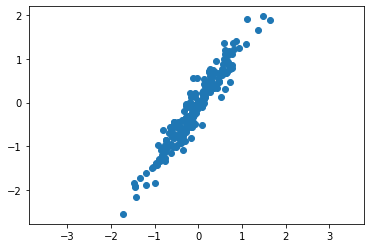

In [4]:
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

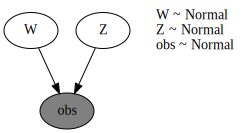

In [5]:
pyro.clear_param_store()


def ppca_model_without_plate(data, latent_dim):
    N, data_dim = data.shape
    W = pyro.sample(
        "W",
        dist.Normal(
            loc=torch.zeros([data_dim, latent_dim]),
            scale=5.0 * torch.ones([data_dim, latent_dim]),
        ).to_event(2)
    )
    Z = pyro.sample(
        "Z",
        dist.Normal(
            loc=torch.zeros([latent_dim, N]),
            scale=torch.ones([latent_dim, N]),
        ).to_event(1),
    )

    mean = (W @ Z).t()
    
    ob = pyro.distributions.Normal(mean, 1.0).to_event(2)
    return pyro.sample("obs", ob, obs=data)


pyro.render_model(
    ppca_model_without_plate, model_args=(X, 1), render_distributions=True
)

In [6]:
ppca_model_without_plate(X, 1).shape

/Users/nipun/miniforge3/lib/python3.9/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs
  warnings.warn(


torch.Size([200, 2])

In [8]:
import pyro.poutine as poutine

trace = poutine.trace(ppca_model_without_plate).get_trace(X, 1)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
x = trace.format_shapes()

In [15]:
table = [["spam",42],["eggs",451],["bacon",0]]
headers = ["item", "qty"]
print(tabulate(table, headers, tablefmt="fancy_grid"))

╒════════╤═══════╕
│ item   │   qty │
╞════════╪═══════╡
│ spam   │    42 │
├────────┼───────┤
│ eggs   │   451 │
├────────┼───────┤
│ bacon  │     0 │
╘════════╧═══════╛


In [19]:
from IPython.display import display, HTML
HTML(tabulate(table, headers, tablefmt="html"))

item,qty
spam,42
eggs,451
bacon,0


In [12]:
from tabulate import tabulate


'-  -  -  -  -  -  -  -  -  -  -  -  -    -    -    -  -  -    -\nT  r  a  c  e     S  h  a  p  e  s  :\n   P  a  r  a  m     S  i  t  e  s  :\nS  a  m  p  l  e     S  i  t  e  s  :\n                     W     d  i  s  t         |          2    1\n                        v  a  l  u  e         |          2    1\n               l  o  g  _  p  r  o  b         |\n                     Z     d  i  s  t    1    |    2  0  0\n                        v  a  l  u  e    1    |    2  0  0\n               l  o  g  _  p  r  o  b    1    |\n               o  b  s     d  i  s  t         |    2  0  0    2\n                        v  a  l  u  e         |    2  0  0    2\n               l  o  g  _  p  r  o  b         |\n-  -  -  -  -  -  -  -  -  -  -  -  -    -    -    -  -  -    -'

In [211]:
pyro.clear_param_store()
auto_guide = pyro.infer.autoguide.AutoNormal(ppca_model_without_plate)

In [193]:
trace = poutine.trace(auto_guide).get_trace(X, 1)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

       Trace Shapes:            
        Param Sites:            
   AutoNormal.locs.W 2   1      
 AutoNormal.scales.W 2   1      
   AutoNormal.locs.Z 1 200      
 AutoNormal.scales.Z 1 200      
       Sample Sites:            
W_unconstrained dist     |   2 1
               value     |   2 1
            log_prob     |      
              W dist     |   2 1
               value     |   2 1
            log_prob     |      
Z_unconstrained dist 1   | 200  
               value 1   | 200  
            log_prob 1   |      
              Z dist 1   | 200  
               value 1   | 200  
            log_prob 1   |      


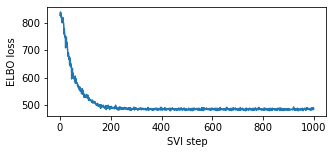

In [194]:
import logging
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(ppca_model_without_plate, auto_guide, adam, elbo)

losses = []
for step in range(1000):  # Consider running for more steps.
    loss = svi.step(X, 1)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

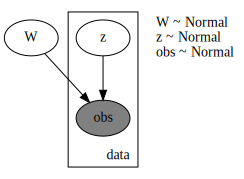

In [198]:
pyro.clear_param_store()


def ppca_model(data, latent_dim):
    N, data_dim = data.shape
    W = pyro.sample(
        "W",
        dist.Normal(
            loc=torch.zeros([data_dim, latent_dim]),
            scale=5.0 * torch.ones([data_dim, latent_dim]),
        ).to_event(2),
    )
   
    with pyro.plate("data", len(data)):
        z_n = pyro.sample("z", dist.Normal(loc=torch.zeros([1, latent_dim]), scale=torch.ones([1, latent_dim])))

        mean = (W@z_n).t()
        y = dist.Normal(mean, 1.).sample()
        d = dist.Normal(mean, 1.)
        e = d.to_event(1)
        pyro.sample("obs", e, obs=data)




pyro.render_model(
    ppca_model, model_args=(X, 1), render_distributions=True
)

In [199]:
auto_guide2 = pyro.infer.autoguide.AutoNormal(ppca_model)

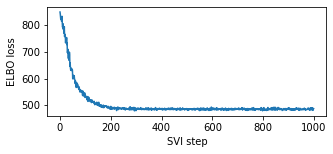

In [200]:
pyro.clear_param_store()
adam = pyro.optim.Adam({"lr": 0.02})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(ppca_model, auto_guide2, adam, elbo)

losses = []
for step in range(1000):  # Consider running for more steps.
    loss = svi.step(X, 1)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");